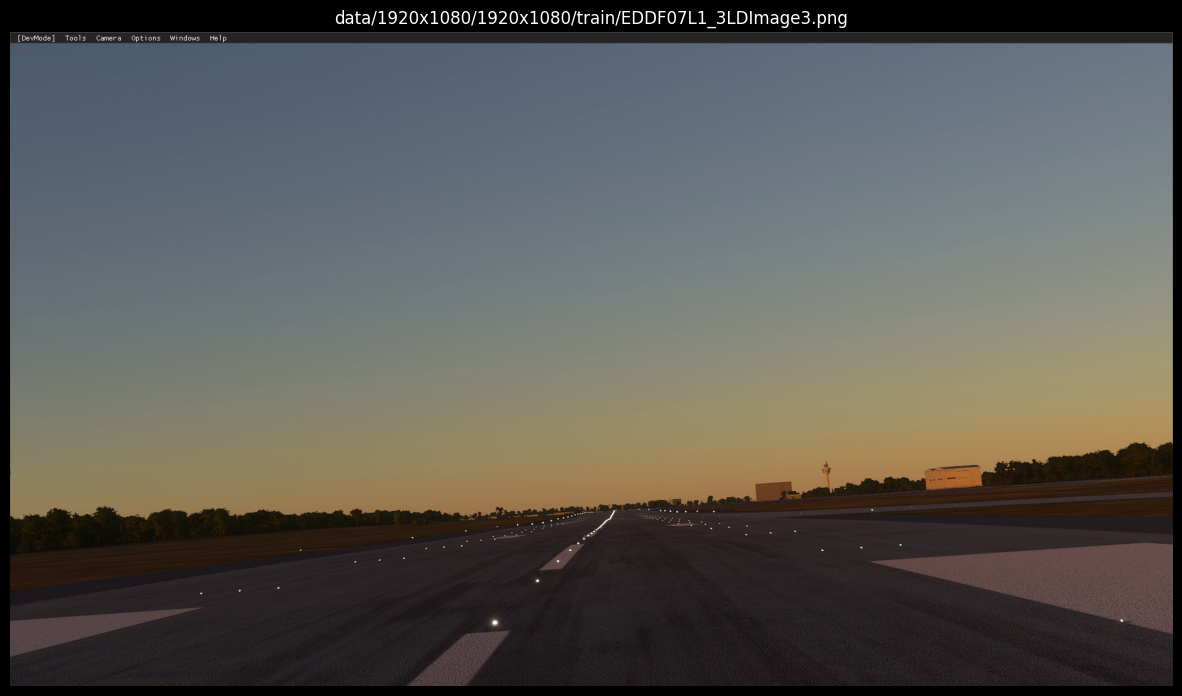

In [1]:
#Look at images
from pathlib import Path
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from mpmath.identification import transforms
from torchvision.ops.misc import interpolate

random.seed(42)
LOCALPATH = Path('data/1920x1080/1920x1080')
KAGGLEPATH = Path('/kaggle/input/fs2020-runway-dataset/1920x1080/1920x1080')

if os.path.exists(KAGGLEPATH):
    target_dir_feature = KAGGLEPATH
else:
    target_dir_feature = LOCALPATH

if target_dir_feature.exists():
    train_dir = target_dir_feature/'train'
    test_dir = target_dir_feature/'test'
    image_path_feature_list = list(train_dir.glob('*.png'))

    if len(image_path_feature_list)>0:

        random_image_path = random.choice(image_path_feature_list)
        image = Image.open(random_image_path)

        plt.figure(figsize=(15,15))
        plt.imshow(image)
        plt.title(random_image_path)
        plt.axis('off')
        plt.show()

    else:
        print(f'No images found in  {train_dir}')

else:
    print('Directory not found')

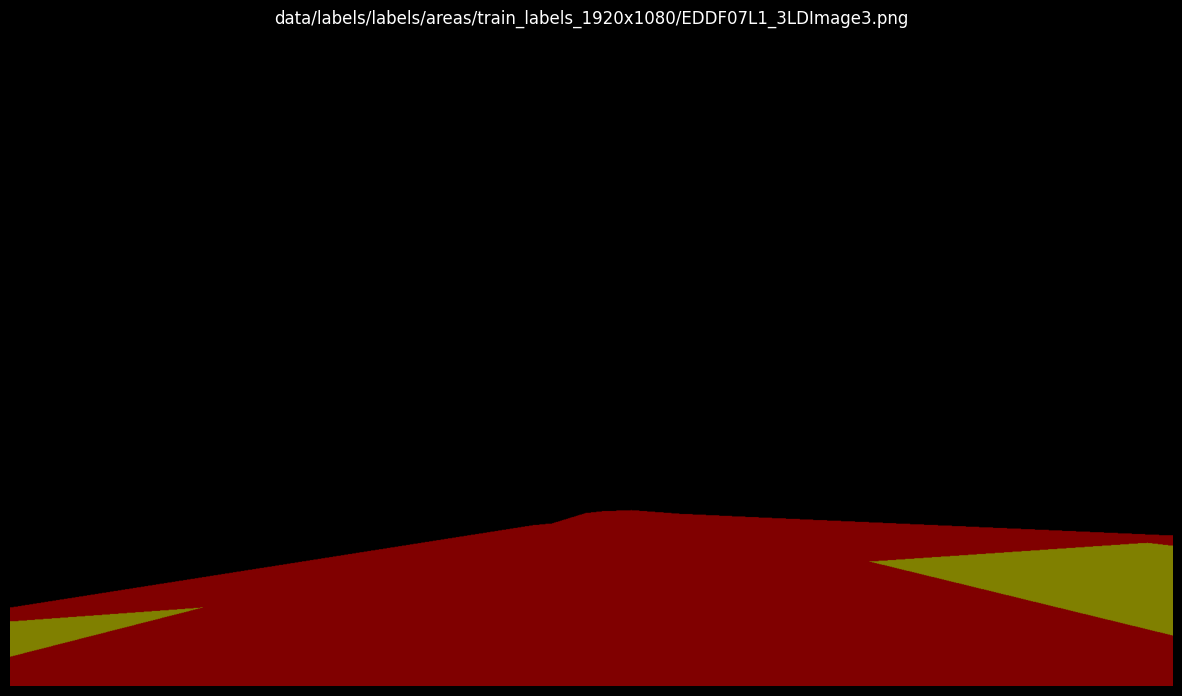

In [2]:
#look at the label masks
LOACLPATHMASKS = Path('data/labels/labels/areas/')
KAGGLEPATHMASKS = Path('/kaggle/input/fs2020-runway-dataset/labels/labels/areas/')
random.seed(42)

if os.path.exists(KAGGLEPATHMASKS):
    target_dir_masks = KAGGLEPATHMASKS
else:
    target_dir_masks = LOACLPATHMASKS

if target_dir_masks.exists():
    train_masks_dir = target_dir_masks/'train_labels_1920x1080/'
    test_masks_dir = target_dir_masks/'test_labels_1920x1080/'

    image_mask_list = list(train_masks_dir.glob('*.png'))
    if len(image_mask_list)>0:
        random_image_mask_path = random.choice(image_mask_list)
        image_mask = Image.open(random_image_mask_path)

        plt.figure(figsize=(15,15))
        plt.imshow(image_mask)
        plt.title(random_image_mask_path)
        plt.axis('off')
        plt.show()

    else:
        print(f'No images found in  {train_dir_labels}')
else:
    print('Directory not found')

In [3]:
#set device agnostics
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [34]:
#TRransforms images as well masks
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ColorJitter(brightness=[max(0, 1 - 0.2), 1 + 0.2],
                           contrast=[max(0, 1 - 0.2), 1 + 0.2],
                           saturation=[max(0, 1 - 0.2), 1 + 0.2],
                           hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

])

mask_transform = transforms.Compose([
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..0.6563062].


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..0.27956167].


torch.Size([256, 256, 3])


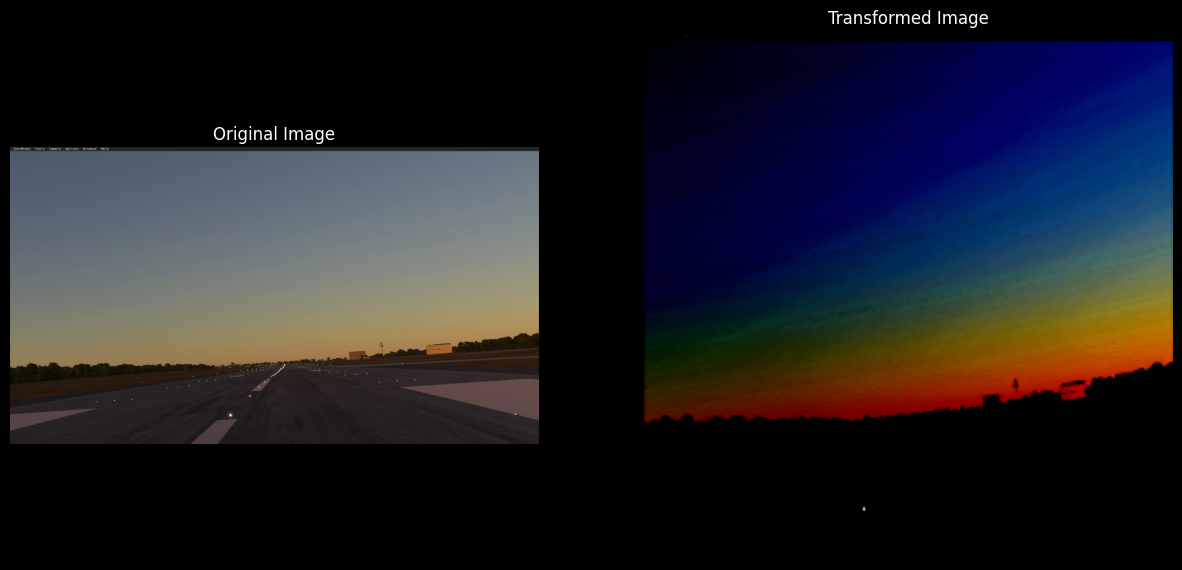

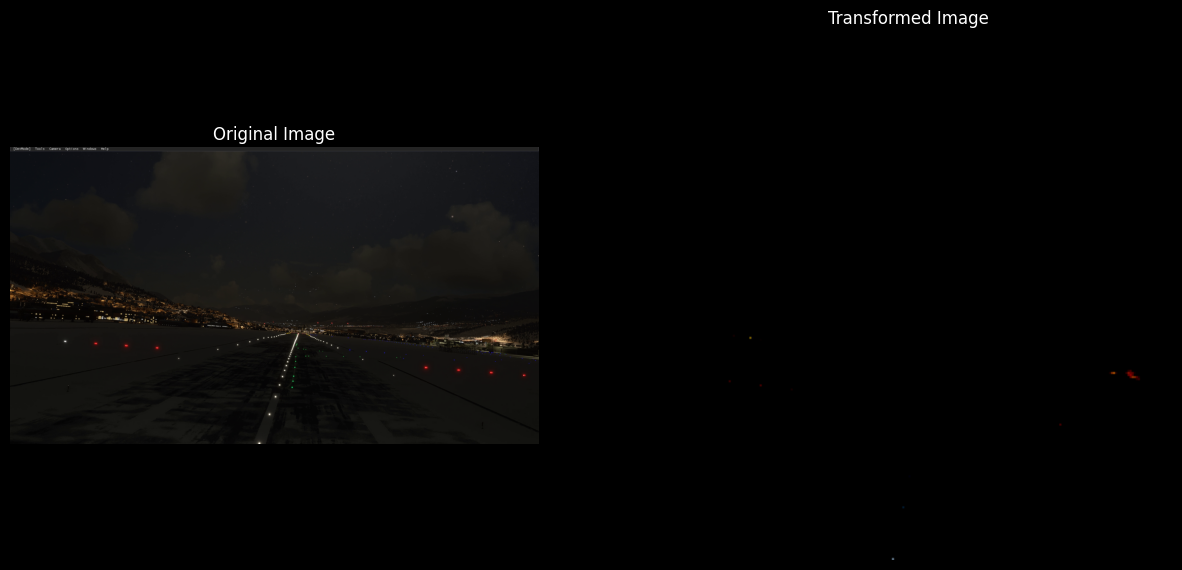

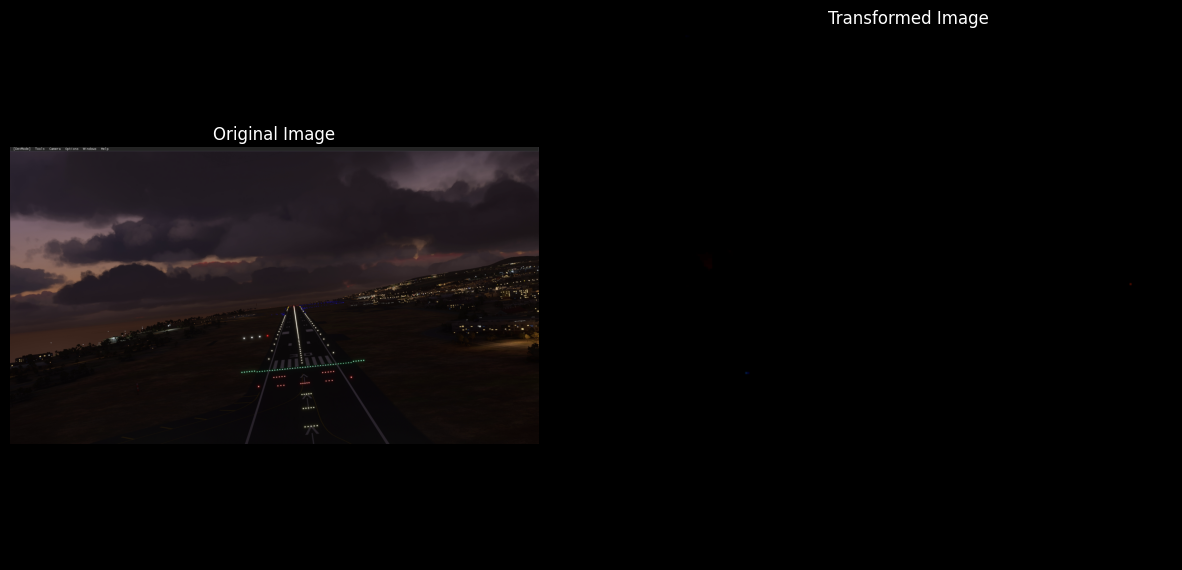

In [35]:
#View Transformed images
random.seed(42)

random_image_path = random.sample(image_path_feature_list,3)

for image_path in random_image_path:
    with Image.open(image_path) as img:
        fig,ax = plt.subplots(1,2, figsize=(15,15))

        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        transformed_img = image_transform(img).permute(1, 2, 0)

        ax[1].imshow(transformed_img)
        ax[1].set_title('Transformed Image')
        ax[1].axis('off')
        shape = transformed_img.shape
        print(shape)

torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])


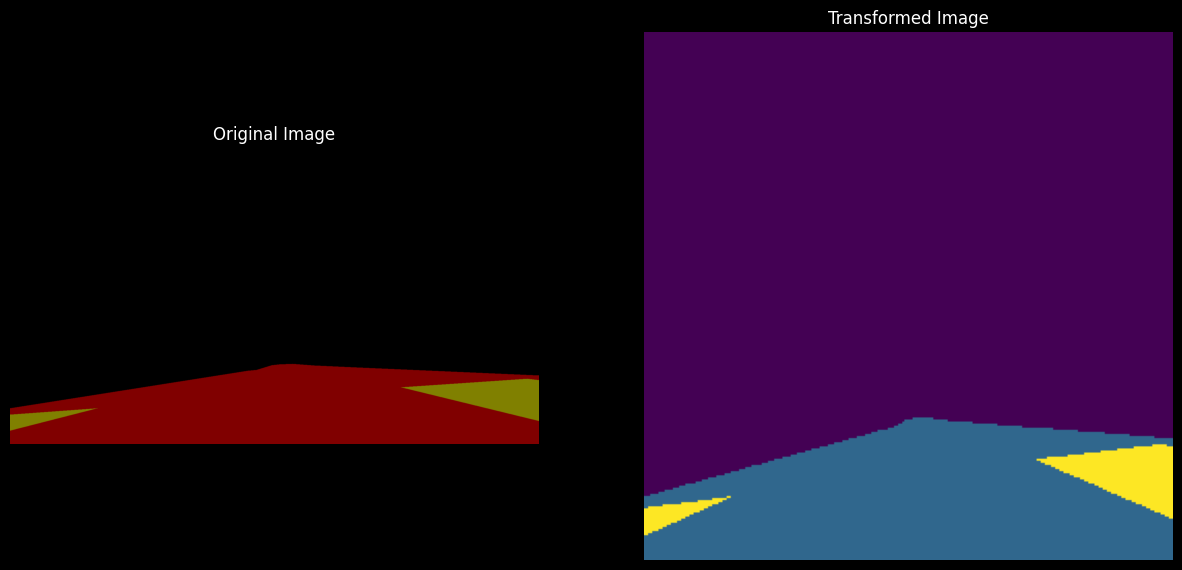

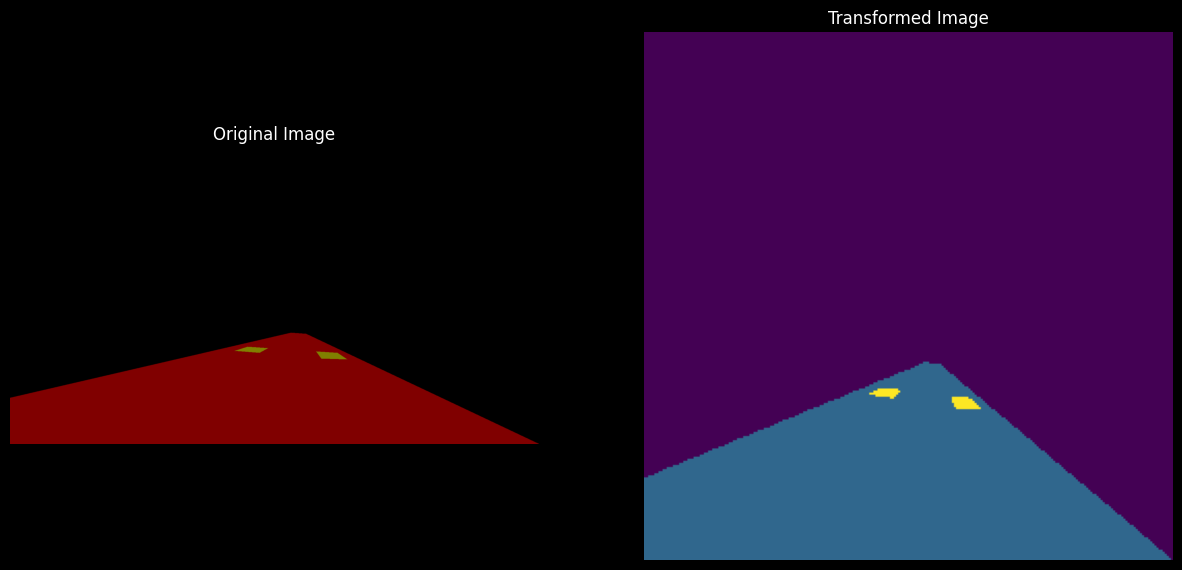

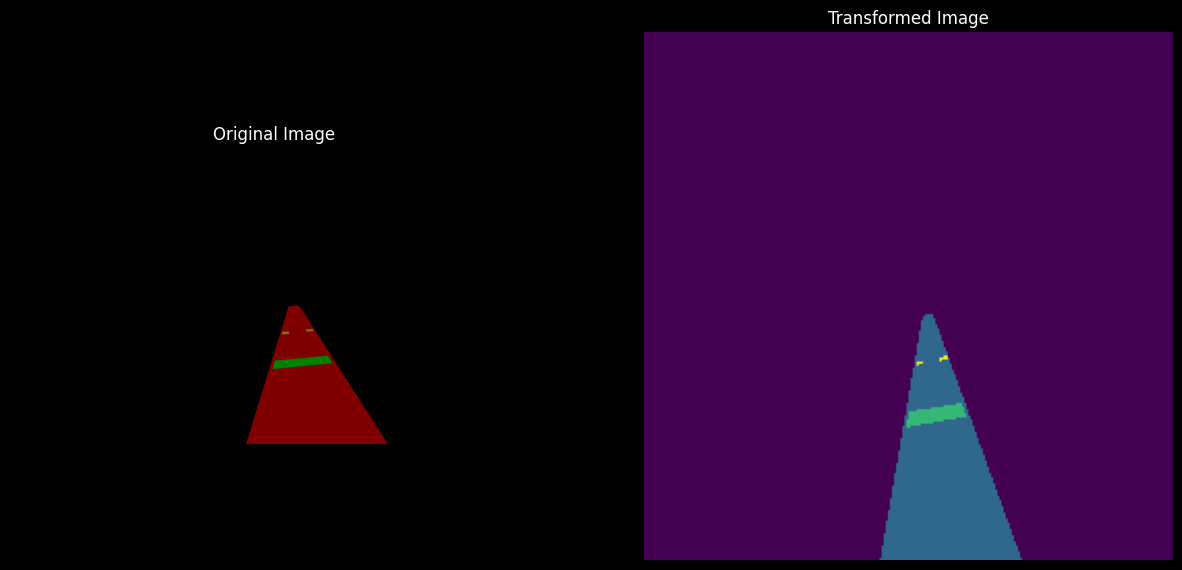

In [36]:
#View Transformed labels
random.seed(42)

random_mask_path = random.sample(image_mask_list,3)

for image_path in random_mask_path:
    with Image.open(image_path) as img:
        fig,ax = plt.subplots(1,2, figsize=(15,15))

        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        transformed_img = mask_transform(img).permute(1, 2, 0)

        ax[1].imshow(transformed_img)
        ax[1].set_title('Transformed Image')
        ax[1].axis('off')
        shape = transformed_img.shape
        print(shape)

In [7]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

class RunwayDataset(Dataset):
    def __init__(self, train_dir,mask_dir, image_transform=None, mask_transform=None):
        self.train_dir = Path(train_dir)
        self.image_transform = image_transform
        self.mask_dir = Path(mask_dir)
        self.mask_transform = mask_transform


        self.image_paths = sorted(list(self.train_dir.glob("*.jpg")) + list(self.train_dir.glob("*.png")))


        self.mask_paths = sorted(list(self.mask_dir.glob("*.png")))


        if len(self.image_paths) != len(self.mask_paths):
            print(f"⚠️ Warning: Found {len(self.image_paths)} images but {len(self.mask_paths)} masks!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path)

        mask = Image.open(mask_path).convert("L")


        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [8]:
train_dataset = RunwayDataset(
    train_dir = train_dir,
    mask_dir = train_masks_dir,
    image_transform = image_transform,
    mask_transform= mask_transform
)

test_dataset = RunwayDataset(
    train_dir =test_dir,
    mask_dir = test_masks_dir,
    image_transform = image_transform,
    mask_transform= mask_transform
)
train_dataset.__getitem__(1)

(tensor([[[-1.1247, -1.1760, -1.1589,  ..., -1.1760, -1.1760, -1.1247],
          [-1.1932, -1.2617, -1.2445,  ..., -1.2617, -1.2617, -1.1932],
          [-1.1932, -1.2617, -1.2274,  ..., -1.2617, -1.2617, -1.1932],
          ...,
          [ 0.0741,  0.0569,  0.0569,  ...,  0.0056, -0.0287, -0.0116],
          [ 0.0398,  0.0398,  0.0398,  ..., -0.0801, -0.0801, -0.0287],
          [-0.0972,  0.0227,  0.0741,  ..., -0.2513, -0.2342, -0.1143]],
 
         [[-1.0378, -1.0728, -1.0728,  ..., -1.0728, -1.0728, -1.0378],
          [-1.0903, -1.1604, -1.1429,  ..., -1.1604, -1.1604, -1.1078],
          [-1.0903, -1.1604, -1.1253,  ..., -1.1604, -1.1604, -1.0903],
          ...,
          [-0.0924, -0.0924, -0.0924,  ..., -0.1099, -0.1275, -0.1099],
          [-0.0924, -0.0924, -0.0924,  ..., -0.1800, -0.1800, -0.1275],
          [-0.1975, -0.0924, -0.0924,  ..., -0.3025, -0.2850, -0.1975]],
 
         [[-0.7587, -0.8284, -0.8284,  ..., -0.8284, -0.8284, -0.7587],
          [-0.8458, -0.9330,

In [9]:
#Load Data
from torch.utils.data import DataLoader

train_data_load = DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=4,
    shuffle = True
)
test_data_load = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=4,
    shuffle = True
)

In [19]:
from torch import nn
#DoubleConvLayer
class DoubleConv2d(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

        )
    def forward(self,x):
        return self.double_conv(x)


In [22]:
#Downgrade resolution
class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv2d(in_channels, out_channels)
        )
    def forward(self,x):
        return self.max_pool(x)

In [21]:
#Upsacle image and merge with results of same level downscaled images
class Up(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        DoubleConv2d(in_channels//2, out_channels)

    def forward(self,x1,x2):
        x = self.up(x1)

        diffY = x2.size()[2]  - x1.size()[2]
        diffX = x2.size()[3]  - x1.size()[3]

        x1 = F.pad(x1,[diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat(x1,x2,dim=1)
        return self.conv(x)


In [14]:
#feature mapping
class Out(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Out,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self,x):
        return self.conv(x)

In [23]:
#Main model class --brain
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes


        self.inc = DoubleConv2d(n_channels, 64)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)


        self.down4 = Down(512, 1024)


        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)


        self.outc = Out(64, n_classes)

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # 2. Going Up (Concatenate with saved outputs)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # 3. Final Prediction
        logits = self.outc(x)
        return logits

In [26]:
#test
model  = UNet(n_channels=3, n_classes=2)
model

UNet(
  (inc): DoubleConv2d(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (max_pool): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv2d(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, moment